In [62]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from functools import partial
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import LogNorm, PowerNorm, BoundaryNorm
from matplotlib import cm
from scipy.ndimage import gaussian_filter1d
import sys
sys.path.append('src')
from Like import Floor_2D
%matplotlib inline

# Plotting functions

In [134]:
def plotdata(ax, filename, label=None, **kwargs):
    data = np.loadtxt(filename)
    kwargs.setdefault('linewidth',3)
    if isinstance(label, str):
        kwargs['label'] = label
        label = None
    lines = ax.plot(*(data.T), **kwargs)
    if label is not None:
        label.setdefault('color', lines[0].get_color())
        label.setdefault('alpha', lines[0].properties()['alpha'])
        label.setdefault('x', 1000)
        label.setdefault('y', np.interp(label['x'], data[:,0], data[:,1])*label.pop('yrel',1.25))
        label.setdefault('size',18)
        label.setdefault('rotation', 25 if label['x'] > 99 else 0)
        ax.text(**label)
    return lines

def makecanvas(xlim=(1e0, 0.999e4), ylim=(1e-49, 1e-41), **kwargs):
    plt.rcParams['axes.linewidth'] = kwargs.get('linewidth',2)
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif', size=kwargs.get('fontsize',25))
    mpl.rcParams['text.latex.preamble'] = r'\usepackage{mathpazo}'

    fig, ax = plt.subplots(figsize=kwargs.get('figsize',(16,15)))
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
    
    
    ax.loglog()
    kwargs.setdefault('labelfontsize',30)
    ax.set_xlabel(kwargs.get('xlabel',"Dark matter mass [GeV/c$^{2}$]"), fontsize=kwargs['labelfontsize'])
    ax.set_ylabel(kwargs.get('ylabel',"Dark matter-nucleon cross section [cm$^{2}$]"),fontsize=kwargs['labelfontsize'])
    
    yax2 = ax.secondary_yaxis('right', functions=(lambda y: y*1e36, lambda y: y*1e-36))
    yax2.set_ylabel('[pb]', fontsize=kwargs['labelfontsize'])
    
    ax.tick_params(which='major',direction='in',width=1,length=15,right=True,top=True,pad=7)
    ax.tick_params(axis='x', which='minor',direction='in',width=1,length=8,right=True,top=True)
    
    ax.plotdata = partial(plotdata, ax)
    ax.plotprojection = partial(plotdata, ax, linestyle='dashed')
    return fig, ax

def plotnufog(fig, ax, target, spin='SI', vmin=1.5, vmax=3, n_div=0.5):
    interval = np.linspace(0.0,0.8)
    colors = cm.Blues(interval)
    cmap = LinearSegmentedColormap.from_list('name', colors)
    data = np.loadtxt(f'data/WIMPlimits/mylimits/DLNuFloor{target}_detailed_{spin}.txt')
    Ex = np.flipud(data[1:,1:])
    floor_idx = 1.5
    m,sig,NUFLOOR,DY = Floor_2D(data,Ex_crit=1e19,slope_idx=floor_idx)
    DY_cut = np.copy(DY)
    for j in range(0,len(m)):
    #for i in reversed(range(0,len(sig))):
        #print(sig[i])
    #    if DY_cut[i,j] >= cut_n:
    #        DY_cut[:i+1,j] = cut_n
    #        break
        for i in reversed(range(0, len(sig)-1)):
            DY_cut[i,j] = max(DY_cut[i,j], DY_cut[i+1,j])
    
    lvl_min = vmin
    lvl_max = 15
    n_lvl = int((lvl_max-lvl_min)/n_div)+1
    levels = np.linspace(lvl_min,lvl_max,n_lvl)
    n_tick = int((vmax-vmin)/n_div)+1
    ticks = np.linspace(vmin,vmax,n_tick)
    cnt = ax.contourf(m,sig,DY_cut,levels=levels,vmin=vmin,vmax=vmax,cmap=cmap,zorder=-100)
    for c in cnt.collections: c.set_edgecolor("face")
    im = ax.pcolormesh(-m,sig,DY,vmin=vmin,vmax=vmax,cmap=cmap,rasterized=True)
    fig.subplots_adjust(top=0.8)
    cbar_ax = fig.add_axes([0.1, 0.82, 0.82, 0.02])
    #fig.colorbar(im, cax=cbar_ax,orientation='horizontal',extend='both',extendfrac=0.03,boundar)
    norm = BoundaryNorm(ticks, cmap.N, extend='both')
    fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cbar_ax,orientation='horizontal',extend='both',extendfrac=0.03)
    cbar_ax.xaxis.set_ticks_position('top')
    cbar_ax.xaxis.set_ticks(ticks)
    #cbar.set_ticklabels([m0,m1,m2,m3,m4])
    plt.gcf().text(0.5,0.88,r'Gradient of %s discovery limit, $n = -({\rm d}\ln\sigma/{\rm d}\ln MT)^{-1}$'%target,fontsize=26,ha='center')
    cbar_ax.tick_params(which='major',direction='in',width=2,length=13,right=True,top=True)
    fig.text(0.14,0.14,f'{target} neutrino fog',color='w',fontsize=35)
    if True:
        # save the floor-exposure data
        floor_expos = np.zeros(len(m))
        for i,mass in enumerate(m):
            E = Ex[:,i]
            y = gaussian_filter1d(gaussian_filter1d(np.log10(E),sigma=3),3)
            dy = -np.gradient(y,np.log10(sig[2])-np.log10(sig[1]))
            dy = gaussian_filter1d(dy,3)
            Efloor = E[dy>2][-1]
            floor_expos[i] = Efloor
            # smooth:
            #floor_expos = gaussian_filter1d(floor_expos,3)
            np.savetxt(f'data/exposure_at_floor/{target}_{spin}.txt',np.column_stack((m,floor_expos)))

def plotexcludedsi(ax):
    data = np.loadtxt('data/published/SI/AllLimits-2021.txt')
    ax.fill_between(*(data.T), ax.get_ylim()[1], edgecolor=None, facecolor='#000000', alpha=0.08)
    alpha=0.4
    #ax.plotdata('data/published/SI/CRESST.txt', alpha=alpha, color='tab:pink', label={'s':'CRESST', 'x':5})
    ax.plotdata('data/published/SI/EDELWEISS.txt', alpha=alpha, color='tab:gray', label={'s':'EDELWEISS', 'x':9, 'y':5e-44})
    ax.plotdata('data/published/SI/CDMSLite.txt', alpha=alpha, color='tab:green', label={'s':'CDMSlite','x':20, 'yrel':1})
    ax.plotdata('data/published/SI/DarkSide.txt', alpha=alpha, color='tab:orange', label={'s':'DarkSide S2','x':1.35, 'y':4e-42})
    ax.plotdata('data/published/SI/DarkSide50.txt',alpha=alpha, color='tab:orange', label={'s':'DarkSide-50', 'yrel':1.15, 'rotation':20})
    ax.plotdata('data/published/SI/DEAP-3600.txt', alpha=alpha, color='tab:brown',
                label={'s':'DEAP-3600'})
    ax.plotdata('data/published/SI/PandaX.txt', alpha=alpha, color='tab:blue',
                label={'s':'PandaX', 'x':1800, 'y':3.5e-45})
    ax.plotdata('data/published/SI/XENON1T.txt', alpha=alpha, color='tab:olive',
                label={'s':'XENON1T', 'yrel': 0.7, 'x':1500})
    ax.plotdata('data/published/SI/LUX.txt', alpha=alpha, color='tab:purple',
                label={'s':'LUX'})
    ax.plotdata('data/published/SI/PICO60.txt', alpha=alpha, color='tab:cyan',
                label={'s':'PICO-60'}, )
    #ax.plotdata('data/published/SI/COSINE-100.txt')


# Spin-independent

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:70: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


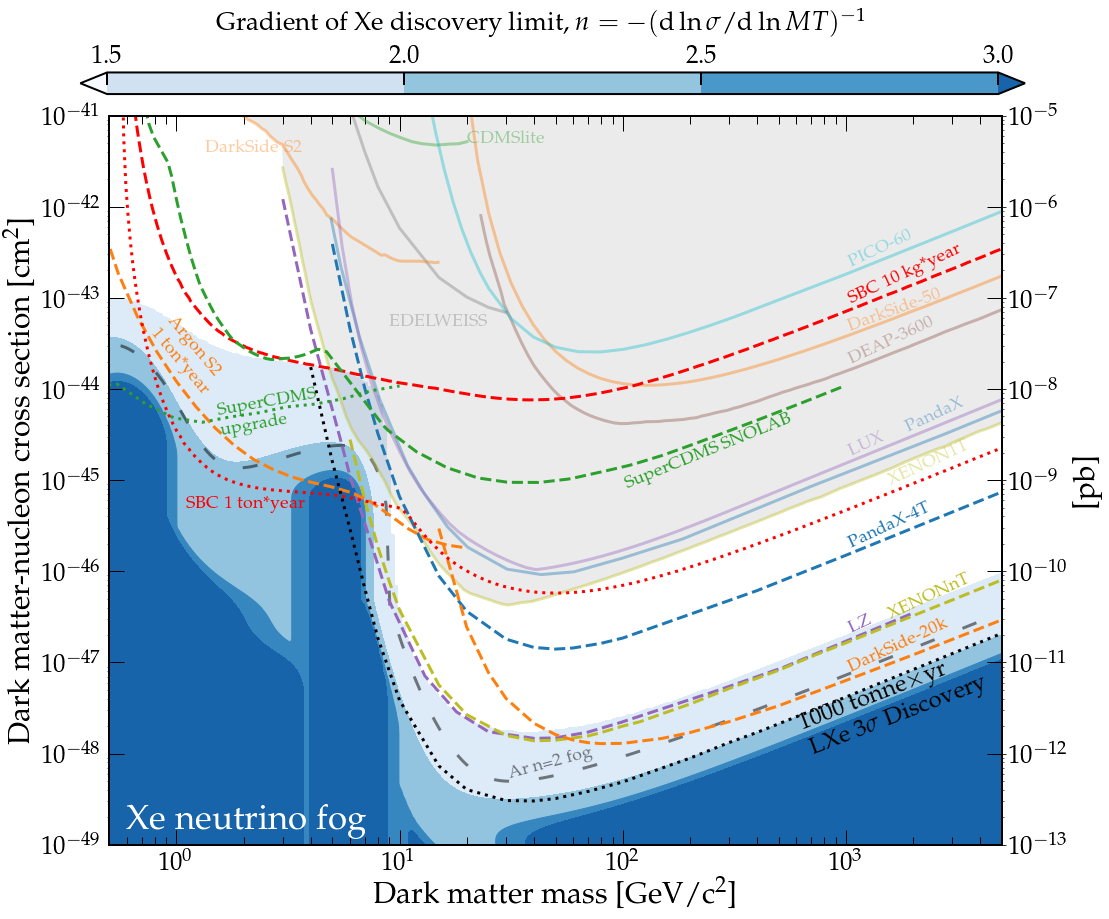

In [153]:
fig, ax = makecanvas(xlim=(0.5, 5000), ylim=(1e-49, 1e-41))
plotexcludedsi(ax)
ax.plotprojection('data/LZ_projected_2019_SI.tsv', color='tab:purple', label={'s':'LZ'})
ax.plotprojection('data/XENONnT_SIproj_20ty_2020.tsv', color='tab:olive', label={'s':'XENONnT', 'x':1500})
ax.plotprojection('data/PandaX-4T_SIproj_6ty_2018.tsv', color='tab:blue', label={'s':'PandaX-4T'})
ax.plotprojection('data/argon_S2only_1tyr_exclusion.tsv', color='tab:orange', label={'s': 'Argon S2\n1 ton*year', 'x':0.75, 'y':9e-45, 'rotation':-50})
ax.plotprojection('data/ds20k_exclusion.tsv', color='tab:orange', label={'s':'DarkSide-20k'})
ax.plotprojection('data/SBC_10kg.tsv', color='red', label={'s': 'SBC 10 kg*year',})# 'x':0.8, 'y':7e-44, 'rotation':-70}, )
ax.plotdata('data/SBC_ton.tsv', color='red', linestyle='dotted', label={'s': 'SBC 1 ton*year', 'x':1.1, 'y':5e-46})
#ax.plotprojection('data/SuperCDMS_SNOLAB_Si_Combined.tsv')
#ax.plotprojection('data/SuperCDMS_SNOLAB_Ge_Combined.tsv')
ax.plotprojection('data/SuperCDMS_SNOLAB_Combined.tsv', color='tab:green', label={'s':'SuperCDMS SNOLAB', 'x':100, 'yrel':0.6, 'rotation':22})
#ax.plotdata('data/SuperCDMS_0VdetA.tsv', color='tab:green', linestyle='dotted', label={'s':'SuperCDMS potential upgrades'})
ax.plotdata('data/SuperCDMS_0VdetC.tsv', color='tab:green', linestyle='dotted', label={'s':'SuperCDMS\nupgrade','x':1.5, 'yrel':0.7,'rotation':10})

g3_disco = np.loadtxt('data/G3_1000tonne-yrs.txt',skiprows=1,delimiter=',',dtype=float)
#plt.plot(g3_disco[:,0],g3_disco[:,1],color='k',linestyle='--',lw=3,alpha=0.99) # 90% limit
plt.plot(g3_disco[:,0],g3_disco[:,2],color='k',linestyle='dotted',lw=3,alpha=0.99) # 3sigma disco
ax.text(600.0,0.1e-47,r'1000 tonne$\times$yr' '\n' r'LXe $3\sigma$ Discovery',color='k',fontsize=24,rotation=21,alpha=1)


#todo: add CDMS, DarkSide-50, Argo, DARWIN
plotnufog(fig, ax, 'Xe')
ax.plotdata('data/floors/Ar_SI.txt', color='k', alpha=0.5, zorder=-50, linestyle=(0, (5, 10)), label={'s':'Ar n=2 fog', 'x':30, 'yrel':1.1, 'rotation':15})
#ax.plotdata('data/floors/Ge_SI.txt', color='g', alpha=0.5, zorder=-50, linestyle=(0, (5, 10)), label={'s':'Ge n=2 fog', 'x':50, 'rotation':15})
plt.savefig('figures/CombinedLimitPlot_SI.pdf')


# Spin-dependent proton

In [285]:
ls data/WIMPLimits/mylimits

ls: cannot access data/WIMPLimits/mylimits/: No such file or directory


# Spin-dependent proton

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:70: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


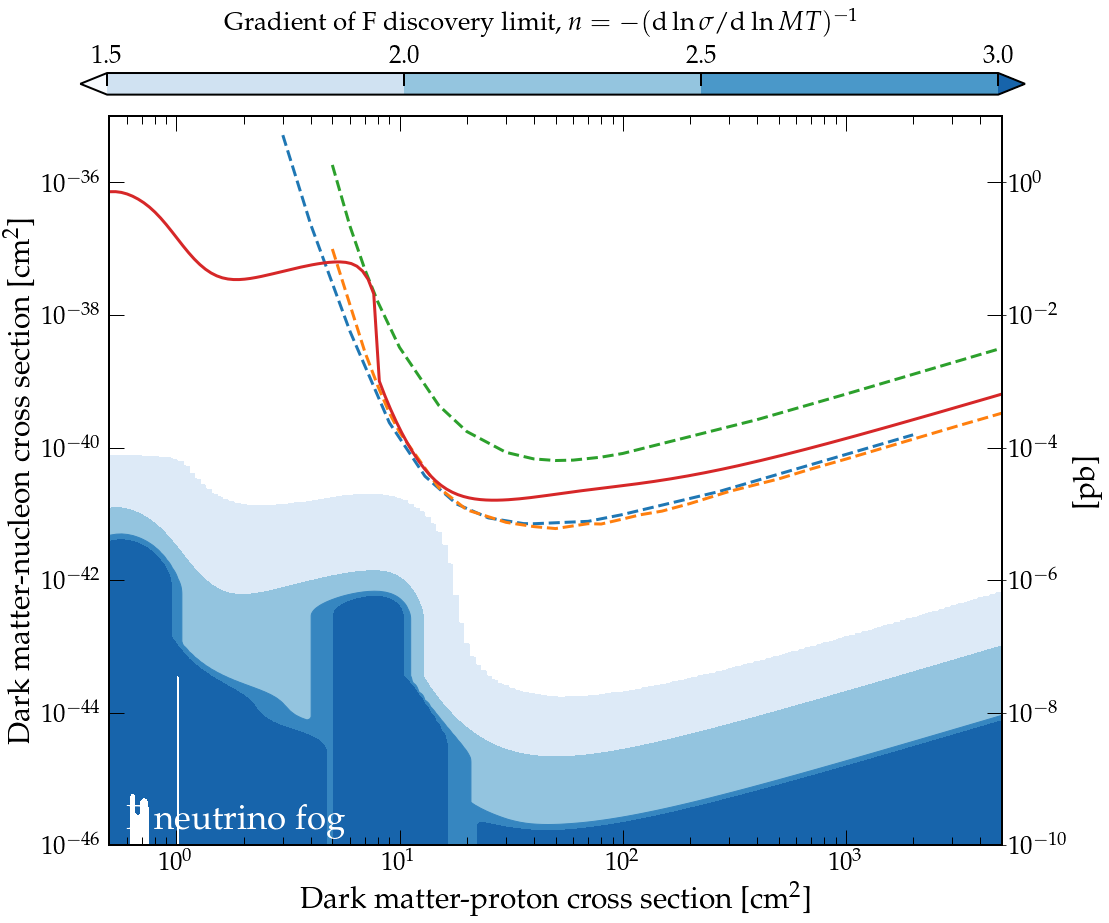

In [161]:
fig, ax = makecanvas(xlim=(0.5, 5000), ylim=(1e-46,1e-35), xlabel='Dark matter-proton cross section [cm$^{2}$]')
ax.plotprojection('data/LZ_projected_2019_SDp.tsv')
ax.plotprojection('data/XENONnT_SD_p_proj_20ty_2020.tsv')
ax.plotprojection('data/PandaX-4T_SDpproj_6ty_2018.tsv')
plotnufog(fig, ax, 'F', 'SDp')
ax.plotdata('data/floors/Xe_SDp.txt')
plt.savefig('figures/CombinedLimitPlot_SDp.pdf')

# Spin dependent exposure to reach fog

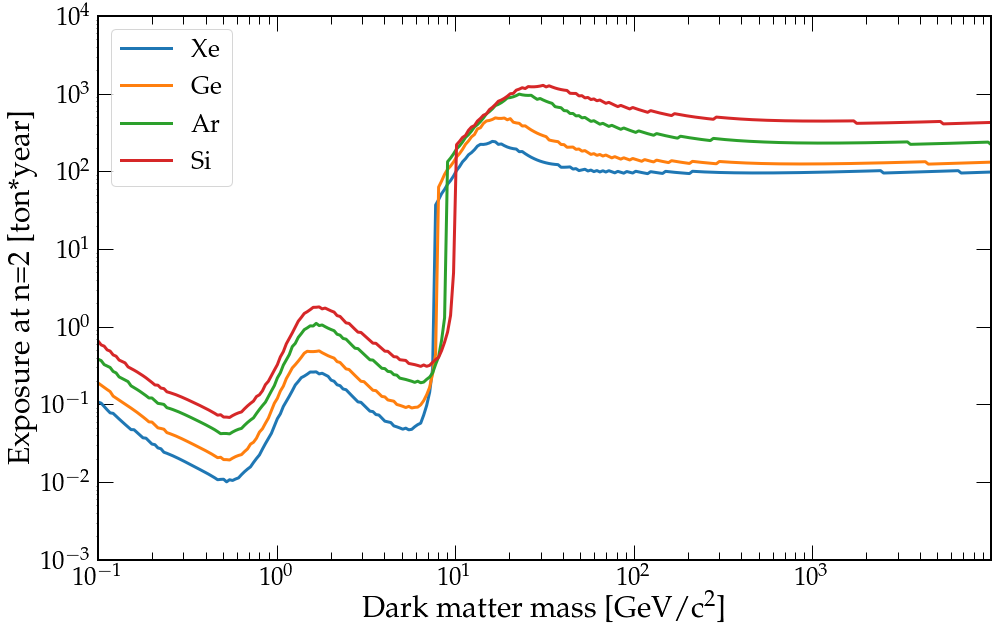

In [164]:
def makecanvas2(xlim=(1e-1, 0.999e4), ylim=(1e-3,1e4), **kwargs):
    plt.rcParams['axes.linewidth'] = kwargs.get('linewidth',2)
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif', size=kwargs.get('fontsize',25))
    mpl.rcParams['text.latex.preamble'] = r'\usepackage{mathpazo}'

    fig, ax = plt.subplots(figsize=kwargs.get('figsize',(16,10)))
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)


    ax.loglog()
    kwargs.setdefault('labelfontsize',30)
    ax.set_xlabel(kwargs.get('xlabel',"Dark matter mass [GeV/c$^{2}$]"), fontsize=kwargs['labelfontsize'])
    ax.set_ylabel(kwargs.get('ylabel',"Exposure at n=2 [ton*year]"),fontsize=kwargs['labelfontsize'])


    ax.tick_params(which='major',direction='in',width=1,length=15,right=True,top=True,pad=7)
    ax.tick_params(axis='x', which='minor',direction='in',width=1,length=8,right=True,top=True)

    ax.plotdata = partial(plotdata, ax)
    ax.plotprojection = partial(plotdata, ax, linestyle='dashed')
    return fig, ax

fig, ax = makecanvas2()
ax.plotdata('data/exposure_at_floor/Xe_SI.txt', label='Xe')
ax.plotdata('data/exposure_at_floor/Ge_SI.txt', label='Ge')
ax.plotdata('data/exposure_at_floor/Ar_SI.txt', label='Ar')
#ax.plotdata('data/exposure_at_floor/F_SI.txt', label='F')
ax.plotdata('data/exposure_at_floor/Si_SI.txt', label='Si')
#ax.plotdata('data/exposure_at_floor/He_SI.txt', label='He')
ax.legend()
plt.savefig('figures/exposure_at_floor_SI.pdf')